<a href="https://colab.research.google.com/github/nhdquyen/Customer-Segmentation-using-KMeans/blob/main/LAB_KMEANS_CUSTOMER_SEGMENTATION_Quyen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB_KMEANS_Customer_Segmentation

If you want to grow your business, it makes sense to put in the effort to understand the characteristics of your customers for at least two reasons: 
1. To continue to provide this group with what they’re looking for and keep them as customers
2. To target your marketing efforts toward prospects who resemble your best customers.

By targeting your acquisition marketing through insights into your best customers, you attract customers who are likely to respond to the strengths of your business and remain loyal to it. **Instead of targeting all customers at once, you can start segment your customers and use different strategy for each group. With this approach, you will also focus on your potential customers to develop strategies for them.**

But, before you can start to understand your best customers, you first need to identify them. And that’s where a simple database marketing tool called recency, frequency, monetary analysis (or RFM) comes in handy.

In our example, we will be using a sample dataset of an online retail.

# 1 - Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/FTMLE | 2021.09 | South Sandwich/Data/OnlineRetail.csv'

# 2 - Load dataset

This dataset contains all purchases made for an online retail company based in the UK during an eight month period.

In [ ]:
df= pd.read_csv(PATH,encoding = "unicode_escape")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# inspect timeline of year-month
(pd.to_datetime(df.InvoiceDate).dt.year.astype('str') + pd.to_datetime(df.InvoiceDate).dt.month.astype('str')).unique()

array(['201012', '20111', '20112', '20113', '20114', '20115', '20116',
       '20117', '20118', '20119', '201110', '201111', '201112'],
      dtype=object)

# 3 - Clean our data

By looking at the data and each columns, you should be able to investigate a bit and do some basic cleaning. We will **drop** some errornous records (or records that don't make sense)


In [ ]:
def drop_values(df):

    # For this problem, we will only look at UK market
    df.drop(df[df.Country!='United Kingdom'].index, inplace=True)
    df.drop('Country',axis=1,inplace=True)

    # only 1 negative unit price
    df.drop(df[df['UnitPrice']<0].index, inplace = True) 
    
    # drop some erroneous records
    df.drop(df[(df['Quantity']<0) & (df['UnitPrice']==0)].index,inplace=True)
    
    # drop nan description
    df.drop(df[df['Description'].isna()].index,inplace=True)
    df.drop(df[df['CustomerID'].isna()].index,inplace=True)

In [ ]:
# run function
drop_values(df)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0
...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,12/9/2011 12:31,1.95,15804.0
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,12/9/2011 12:49,2.95,13113.0
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,12/9/2011 12:49,1.25,13113.0
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,12/9/2011 12:49,8.95,13113.0


# 4 - Feature engineering

For this section, we will create some features that we think is going to be useful for our data analysis/visualization and our end goal: **segment customer into different groups**. There is one new column that you can create immediately from this datasetdataset, that is Revenue

In [ ]:
def create_date_features(df,date_feature):
    df[date_feature] = pd.to_datetime(df[date_feature])
    df['Year'] = df[date_feature].dt.year
    df['Month'] = df[date_feature].dt.month
    df['Day'] = df[date_feature].dt.day
    df['DayOfWeek'] = df[date_feature].dt.day
    df['WeekOfYear']= df[date_feature].dt.week

In [ ]:
create_date_features(df,'InvoiceDate')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,1,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,2010,12,1,1,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48


In [ ]:
# Create column that shows Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,1,48,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,2010,12,1,1,48,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34


# 5 - Calculate New Customer Ratio, Retention Rate and perform visualization using pandas and seaborn

In [ ]:
# let's make a copy of our dataframe since df is a mutable data type
df_plots = df.copy()

For an online retail, we can select our metric (something that can help the company grows) as **Monthly Revenue**. Let’s see how our data look like on jupyter notebook.

**Important**: For the rest of the EDA, we will calculate some metrics **monthly**, so it will be convenient that for our dataframe, we can add a column to show year + month. We will call this column **InvoiceYearMonth**

In [ ]:
df_plots['InvoiceDate'][0].year

2010

In [ ]:
# self-note: iterator của map là cột InvoiceDate, lấy từng dòng (kết quả của 1 lần iter) .year/.month để extract phần tử tương ứng
df_plots['InvoiceYearMonth'] = df_plots['InvoiceDate'].map(lambda date: 100*date.year + date.month) 
df_plots.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,1,48,15.30,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,2010,12,1,1,48,22.00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34,201012


## Monthly Revenue and Percentage change for each month

In [ ]:
# create a dataframe that stores the revenue for each month
monthly_revenue = df_plots.groupby('InvoiceYearMonth')['Revenue'].sum().reset_index()
monthly_revenue.head(5)

,InvoiceYearMonth,Revenue
0,201012,483799.740
1,201101,351981.280
2,201102,348853.630
3,201103,456917.870
4,201104,376744.411


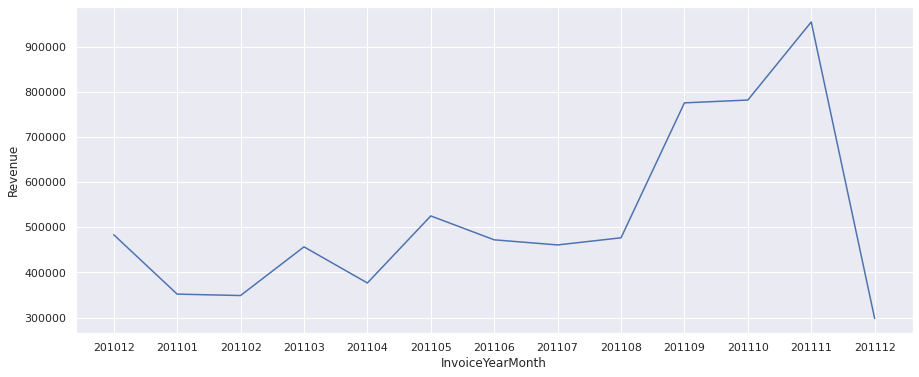

In [ ]:
# Plot monthly revenue
monthly_revenue.InvoiceYearMonth = monthly_revenue.InvoiceYearMonth.astype(str)
sns.set_theme(style="darkgrid")

plt.figure(figsize= (15,6))
sns.lineplot(data = monthly_revenue, x = 'InvoiceYearMonth', y = 'Revenue')

In general, revenue is growing, especially from August 2011. Focus on a big drop in revenue in December 2011. Why is there a big drop, especially in December?

First common reason is data was not collected for the whole month.

In [ ]:
# inspect the date of data collected for December 2011
df_plots[df_plots.InvoiceYearMonth == 201112].Day 

516384    1
516385    1
516386    1
516387    1
516388    1
         ..
541889    9
541890    9
541891    9
541892    9
541893    9
Name: Day, Length: 16077, dtype: int64

**ANSWER:** sales data in this period of time wasn't collected full month (last day recorded was Dec 9)

## New customer ratio and Retention rate

** Steps to find New Customer Ratio**

1. Create a dataframe that contains CustomerId and their earliest InvoiceDate (also known as earliest purchase date)
2. Since we are doing this monthly, we only need to consider Month and Year of this date
3. Merge this dataframe to the df_plots dataframe
4. Create a new column called UserType
- If a user's earliest InvoiceDate is after their current InvoiceDate: this is existing user
- If a user's earliest InvoiceDate is the same as their current InvoiceDate: this is new user

In [ ]:
df_plots.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,1,48,15.30,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34,201012


In [ ]:
# df to show earliest purchase date for each CustomerID
customer_min_purchase = df_plots.groupby('CustomerID')['InvoiceDate'].min().reset_index()
customer_min_purchase

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12747.0,2010-12-05 15:38:00
2,12748.0,2010-12-01 12:48:00
3,12749.0,2011-05-10 15:25:00
4,12820.0,2011-01-17 12:34:00
...,...,...
3945,18280.0,2011-03-07 09:52:00
3946,18281.0,2011-06-12 10:53:00
3947,18282.0,2011-08-05 13:35:00
3948,18283.0,2011-01-06 14:14:00


In [ ]:
customer_min_purchase['MinPurchaseYearMonth'] = customer_min_purchase['InvoiceDate'].map(lambda date: 100*date.year + date.month) 
customer_min_purchase.rename(columns = {'InvoiceDate': 'MinPurchaseDate'}, inplace = True)
df_plots = df_plots.merge(customer_min_purchase, how = 'left', on = 'CustomerID')
df_plots.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,InvoiceYearMonth,MinPurchaseDate,MinPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,1,48,15.30,201012,2010-12-01 08:26:00,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34,201012,2010-12-01 08:26:00,201012


In [ ]:
# Create a new column called UserType
# If a user's earliest InvoiceDate is after their current InvoiceDate: this is existing user
# If a user's earliest InvoiceDate is the same as their current InvoiceDate: this is new user
def user_type(row):
  return 'Existing' if row['InvoiceYearMonth'] > row['MinPurchaseYearMonth'] else 'New'
  
df_plots['UserType'] = df_plots.apply(user_type, axis = 1)
df_plots.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear,Revenue,InvoiceYearMonth,MinPurchaseDate,MinPurchaseYearMonth,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,1,48,15.30,201012,2010-12-01 08:26:00,201012,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,1,48,20.34,201012,2010-12-01 08:26:00,201012,New


We have successfully identify the New and Existing customers for each month.

While we are at it, let's calculate the monthly revenue generated by each UserType. We want to see what is the total revenue generated by New user and total revenue generated by Existing user, for each month.

In [ ]:
# Monthly revenue by user type monthly 
monthly_revenue = df_plots.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
monthly_revenue

,InvoiceYearMonth,UserType,Revenue
0,201012,New,483799.740
1,201101,Existing,195275.510
2,201101,New,156705.770
3,201102,Existing,220994.630
4,201102,New,127859.000
5,201103,Existing,296350.030
6,201103,New,160567.840
7,201104,Existing,268226.660
8,201104,New,108517.751
9,201105,Existing,434725.860


Note: let's exclude the first month (Dec 2010) so the UserType will make more sense, and we will also exclude the last month (Dec 2011) as we don't have enough data in Dec 2011

In [ ]:
# Remove data in Dec 2010 and Dec 2011
monthly_revenue_by_user = monthly_revenue[~monthly_revenue['InvoiceYearMonth'].isin([201012, 201112])]
monthly_revenue_by_user.InvoiceYearMonth = monthly_revenue_by_user.InvoiceYearMonth.astype(str)
monthly_revenue_by_user

,InvoiceYearMonth,UserType,Revenue
1,201101,Existing,195275.510
2,201101,New,156705.770
3,201102,Existing,220994.630
4,201102,New,127859.000
5,201103,Existing,296350.030
6,201103,New,160567.840
7,201104,Existing,268226.660
8,201104,New,108517.751
9,201105,Existing,434725.860
10,201105,New,90847.490


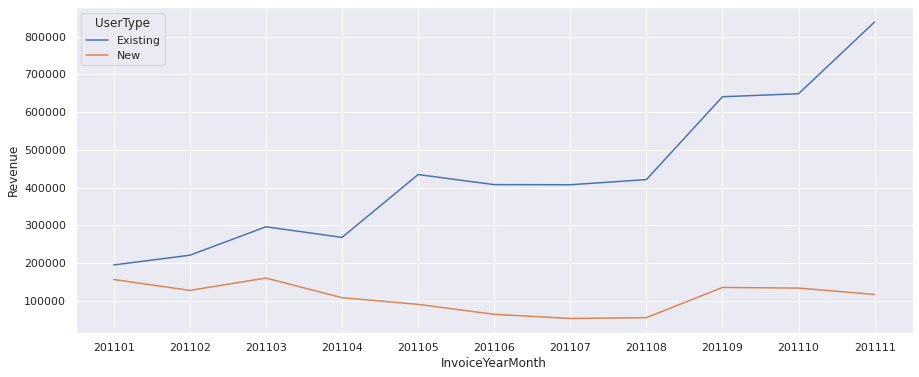

In [ ]:
# Let's plot the monthly revenue for each UserType 
plt.figure(figsize = (15,6))
sns.lineplot(data = monthly_revenue_by_user, x = 'InvoiceYearMonth', y = 'Revenue', hue = 'UserType' )

Existing customers are showing a positive trend and tell us that our customer base is growing. New customers, however, have a slight negative trend between March 2011 to August 2011.

### Retention Rate: ###
1. Create a crosstab between CustomerID and InvoiceYearMonth
2. Create an array of dictionary which keeps Retained & Total User count for each month



In [ ]:
#identify which users are active by looking at their revenue per month
user_purchase = df_plots.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()
user_purchase.head()

,CustomerID,InvoiceYearMonth,Revenue
0,12346.0,201101,0.00
1,12747.0,201012,706.27
2,12747.0,201101,303.04
3,12747.0,201103,310.78
4,12747.0,201105,771.31


In [ ]:
#create retention matrix
retention = pd.pivot_table(data=user_purchase,
                           index='CustomerID',
                           columns='InvoiceYearMonth',
                           values='Revenue',
                           aggfunc='count',
                           fill_value=0).reset_index()

retention.head()

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


In [ ]:
months = retention.columns[1:-1] # skip the last month
months

Index([201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108,
       201109, 201110, 201111],
      dtype='object', name='InvoiceYearMonth')

In [ ]:
#create an array of dictionary which keeps Retained & Total User count for each month
months = retention.columns[1:-1] # skip the first and last month

retention_list = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = selected_month
    retention_data['TotalUserCount'] = retention[selected_month].sum()
    retention_data['RetainedUserCount'] = retention.loc[(retention[selected_month]>0) & (retention[prev_month]>0),selected_month].sum()
    retention_list.append(retention_data)

(self explanation)

In [ ]:
selected_month

201111

In [ ]:
# .loc[a,b] chọn điểm giao giữa dòng a và cột b
# .loc[[a,b]] chọn dòng a và b
retention.loc[(retention[selected_month]>0) & (retention[prev_month]>0),selected_month].sum() 
# chọn dòng thoả 2 điều kiện tại cột (series) rồi sum lại 

616

In [ ]:
# thử làm theo đặt điều kiện cho cột
retention[(retention[selected_month]>0) & (retention[prev_month]>0)][selected_month].sum() # cũng tương tự như cách trên nhưng đi theo cột trước dòng sau.
# lưu ý: biến selected_month và prev_month là các biến trượt theo vòng for loop

616

In [ ]:
# check 
retention_list

[{'InvoiceYearMonth': 201101, 'RetainedUserCount': 322, 'TotalUserCount': 684},
 {'InvoiceYearMonth': 201102, 'RetainedUserCount': 263, 'TotalUserCount': 714},
 {'InvoiceYearMonth': 201103, 'RetainedUserCount': 305, 'TotalUserCount': 923},
 {'InvoiceYearMonth': 201104, 'RetainedUserCount': 310, 'TotalUserCount': 817},
 {'InvoiceYearMonth': 201105, 'RetainedUserCount': 369, 'TotalUserCount': 985},
 {'InvoiceYearMonth': 201106, 'RetainedUserCount': 417, 'TotalUserCount': 943},
 {'InvoiceYearMonth': 201107, 'RetainedUserCount': 379, 'TotalUserCount': 899},
 {'InvoiceYearMonth': 201108, 'RetainedUserCount': 391, 'TotalUserCount': 867},
 {'InvoiceYearMonth': 201109,
  'RetainedUserCount': 417,
  'TotalUserCount': 1177},
 {'InvoiceYearMonth': 201110,
  'RetainedUserCount': 502,
  'TotalUserCount': 1285},
 {'InvoiceYearMonth': 201111,
  'RetainedUserCount': 616,
  'TotalUserCount': 1548}]

In [ ]:
# put into a dataframe and calculate retention rate 
retention_df= pd.DataFrame(retention_list)
retention_df['RetentionRate'] = retention_df['RetainedUserCount']/retention_df['TotalUserCount']
retention_df

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201101,684,322,0.470760
1,201102,714,263,0.368347
2,201103,923,305,0.330444
3,201104,817,310,0.379437
4,201105,985,369,0.374619
5,201106,943,417,0.442206
6,201107,899,379,0.421580
7,201108,867,391,0.450980
8,201109,1177,417,0.354291
9,201110,1285,502,0.390661


Plot Retention rate vs month

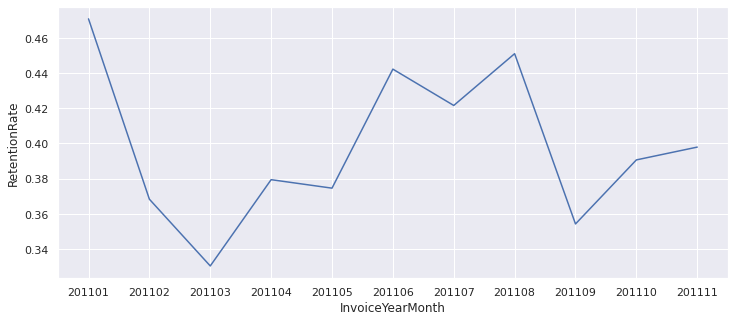

In [ ]:
# Plot Retention rate by month
retention_df.InvoiceYearMonth = retention_df.InvoiceYearMonth.map(str)
plt.figure(figsize= (12,5))
sns.lineplot(data=retention_df,x='InvoiceYearMonth',y='RetentionRate')

Monthly Retention Rate significantly jumped from June to August and went back to previous levels afterwards. Let's take a dive into September 2011 as there is a massive drop (45% down to 35%)

# 6 - Customer Segmentation

There are many different segmentations according to what we are trying to achieve. If we wish to increase retention rate, we can do a segmentation based on churn probability and take actions. 

**There are some common and useful segmentation methods as well. We are going to implement one of them to our business: RFM.**

**RFM stands for Recency - Frequency - Monetary Value.**

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

Theoretically we will have segments like below:

- **Low Values**: Customers who are less active than others, not very frequent buyer/visitor and generates very low or zero net revenue.
- **Mid Values**: In the middle of everything. Using our platform oftently (but not as much as our High Values), fairly frequent and generates moderate revenue.
- **High Values**: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

## Recency

**How can we calculate Recency in this dataset**
- Find out most recent purchase date of each customer and **see how many days they are inactive for**
- After having number of inactive days for each customer, **we will apply K-means clustering to assign customers a recency score.**

**Why do we need this**

- The more recently a customer has made a purchase with a company, the more likely he or she will continue to keep the business and brand in mind for subsequent purchases
- Such information can be used to remind recent customers to revisit the business soon to continue meeting their purchase needs. Marketing efforts could be made to remind them that it has been a while since their last transaction while offering them an incentive to rekindle their interests.

Steps:
1. Find the latest InvoiceDate for each Customer
2. Find the differences between the latest date of our entire dataset and the latest InvoiceDate for each customer. This will be the Recency

In [ ]:
max_purchase_date = df_plots.groupby('CustomerID')['InvoiceDate'].max().reset_index()
max_purchase_date

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00
...,...,...
3945,18280.0,2011-03-07 09:52:00
3946,18281.0,2011-06-12 10:53:00
3947,18282.0,2011-12-02 11:43:00
3948,18283.0,2011-12-06 12:02:00


In [ ]:
Recency = df_plots['InvoiceDate'].max() - max_purchase_date['InvoiceDate']
Recency

0      325 days 02:32:00
1        1 days 22:15:00
2        0 days 00:29:00
3        3 days 02:53:00
4        2 days 21:37:00
              ...       
3945   277 days 02:57:00
3946   180 days 01:56:00
3947     7 days 01:06:00
3948     3 days 00:47:00
3949    42 days 03:20:00
Name: InvoiceDate, Length: 3950, dtype: timedelta64[ns]

In [ ]:
# Recency = (Recency / np.timedelta64(1,'D')).astype(int) if time delta is in day unit

In [ ]:
Recency = Recency.dt.days
max_purchase_date['Recency'] = Recency
recency = max_purchase_date
recency

,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277
3946,18281.0,2011-06-12 10:53:00,180
3947,18282.0,2011-12-02 11:43:00,7
3948,18283.0,2011-12-06 12:02:00,3


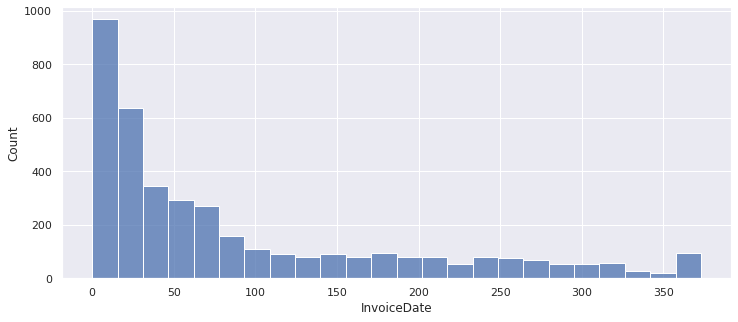

In [ ]:
plt.figure(figsize = (12,5))
sns.histplot(data = Recency)

### Apply kmeans on Recency to put users in groups

Using elbow method to approximate the number of clusters

In [ ]:
X = recency[['Recency']]
X.shape

(3950, 1)

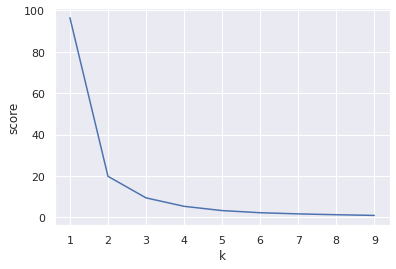

In [ ]:
# Visulization to find the elbow
from sklearn.cluster import KMeans

k_values = range(1,10)
k_mean_models = [KMeans(n_clusters=k) for k in k_values]
scores = [kmean.fit(X).score(X) for kmean in k_mean_models]

norm_scores = [score/max(scores) for score in scores]

plt.plot(k_values,norm_scores)
plt.xlabel('k')

plt.xticks(range(1, 10))
plt.ylabel('score');

For this LAB we will use K = 4 to help with the diversity of our customer segmentation

In [ ]:
k = 4
kmeans = KMeans(n_clusters = k)
kmeans.fit(X)
recency['RecencyCluster'] = kmeans.predict(X)

recency

,CustomerID,InvoiceDate,Recency,RecencyCluster
0,12346.0,2011-01-18 10:17:00,325,0
1,12747.0,2011-12-07 14:34:00,1,3
2,12748.0,2011-12-09 12:20:00,0,3
3,12749.0,2011-12-06 09:56:00,3,3
4,12820.0,2011-12-06 15:12:00,2,3
...,...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277,0
3946,18281.0,2011-06-12 10:53:00,180,2
3947,18282.0,2011-12-02 11:43:00,7,3
3948,18283.0,2011-12-06 12:02:00,3,3


We will use the function below for this task (Make sure to set ascending)

In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [ ]:
recency = order_cluster('RecencyCluster', 'Recency',recency, ascending = False)
recency.drop(columns = 'InvoiceDate', inplace = True)
recency.head()

,CustomerID,Recency,RecencyCluster
0,12346.0,325,0
1,12829.0,321,0
2,12831.0,261,0
3,12834.0,282,0
4,12845.0,266,0


In [ ]:
recency.groupby('RecencyCluster').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


Higher score for Recency = better customers (as their inactive time is low)

## Frequency

**Why do we need this**

The frequency of a customer’s transactions may be affected by factors such as the type of product, the price point for the purchase, and the need for replenishment or replacement. 

In order to increase customers' frequency, we can try to predict their purchase cycle, for example when a customer needs to buy new groceries, marketing efforts could be directed towards reminding them to visit the business when items such as eggs or milk have been depleted.

How can we calculate frequency for this dataset? We just need to find total number orders for each customer.

In [ ]:
# Dataframe to show Frequency of each CustomerID
frequency = df_plots.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns = {'InvoiceDate': 'Frequency'}, inplace = True)
frequency

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59
...,...,...
3945,18280.0,10
3946,18281.0,7
3947,18282.0,13
3948,18283.0,756


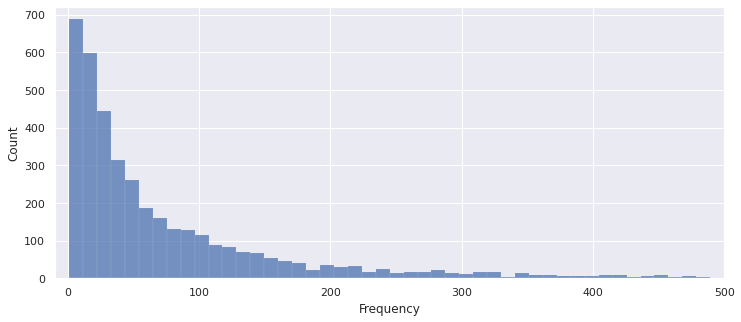

In [ ]:
plt.figure(figsize = (12,5))
sns.histplot(data = frequency['Frequency'])
plt.xlim(-10,500)
plt.show()

### Applying kmeans

Used the same K as above to keep the range of score consistent

In [ ]:
X = frequency[['Frequency']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
frequency['FrequencyCluster'] = kmeans.predict(X)

In [ ]:
#order the frequency cluster
frequency = order_cluster('FrequencyCluster', 'Frequency',frequency,True)
frequency.head()

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,0
1,12747.0,103,0
2,12820.0,59,0
3,12821.0,6,0
4,12822.0,47,0


In [ ]:
#see details of each cluster
frequency.groupby('FrequencyCluster').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


As the same notation as recency clusters, high frequency number indicates better customers.

## Revenue

In [ ]:
# Dataframe to show revenue by each CustomerID
revenue = df_plots.groupby('CustomerID')['Revenue'].sum().reset_index()
revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


(-1000.0, 6000.0)

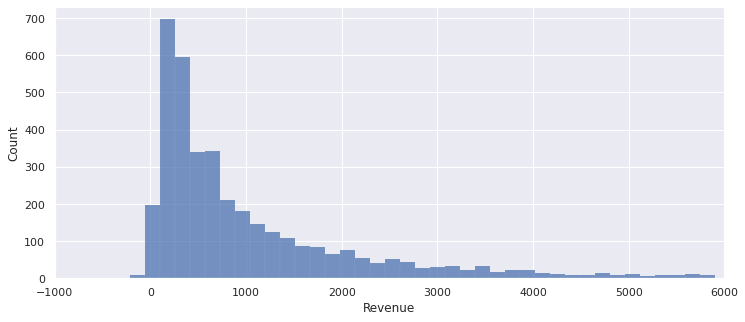

In [ ]:
plt.figure(figsize = (12,5))
sns.histplot(revenue['Revenue'])
plt.xlim(-1000,6000)

In [ ]:
# Apply Kmeans
X = revenue[['Revenue']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
revenue['RevenueCluster'] = kmeans.predict(X)

In [ ]:
#order the cluster numbers
revenue = order_cluster('RevenueCluster', 'Revenue',revenue,True)
revenue

,CustomerID,Revenue,RevenueCluster
0,12346.0,0.00,0
1,12747.0,4196.01,0
2,12749.0,3868.20,0
3,12820.0,942.34,0
4,12821.0,92.72,0
...,...,...,...
3945,18225.0,5361.02,1
3946,18226.0,5192.10,1
3947,18229.0,7276.90,1
3948,17450.0,187482.17,3


In [ ]:
#show details of the dataframe
revenue.groupby('RevenueCluster').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


# 7 - Calculate RFM score for each customer

Merge recency, frequency and revenue together using pandas

In [ ]:
recency.head(2)

,CustomerID,Recency,RecencyCluster
0,12346.0,325,0
1,12829.0,321,0


In [ ]:
frequency.head(2)

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,0
1,12747.0,103,0


In [ ]:
revenue.head(2)

,CustomerID,Revenue,RevenueCluster
0,12346.0,0.00,0
1,12747.0,4196.01,0


In [ ]:
final_rfm = recency.merge(frequency, on = 'CustomerID').merge(revenue, on = 'CustomerID')
final_rfm 

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.0,325,0,2,0,0.00,0
1,12829.0,321,0,12,0,253.05,0
2,12831.0,261,0,9,0,215.05,0
3,12834.0,282,0,18,0,312.38,0
4,12845.0,266,0,27,0,354.09,0
...,...,...,...,...,...,...,...
3945,18252.0,50,2,98,0,526.67,0
3946,18255.0,88,2,6,0,103.30,0
3947,18265.0,71,2,46,0,801.51,0
3948,18277.0,57,2,9,0,97.63,0


Here we value Revenue more than Recency and Frequency, so we give it some weight.

This depends of the bussiness goal of the company.

In [ ]:
final_rfm['RFM_score'] = final_rfm.RecencyCluster + final_rfm.FrequencyCluster + final_rfm.RevenueCluster*2
final_rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score
0,12346.0,325,0,2,0,0.00,0,0
1,12829.0,321,0,12,0,253.05,0,0
2,12831.0,261,0,9,0,215.05,0,0
3,12834.0,282,0,18,0,312.38,0,0
4,12845.0,266,0,27,0,354.09,0,0


In [ ]:
final_rfm.groupby('RFM_score')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
RFM_score,,,
0,304.584388,21.995781,303.339705
1,185.094643,32.310714,478.070770
2,78.802832,46.834423,840.153336
3,20.861886,68.438911,1079.151608
4,16.495868,302.942149,2666.011529
5,17.238806,154.910448,7469.424776
6,9.841727,377.985612,7819.577122
7,7.318182,888.863636,17212.819545
8,8.083333,403.916667,41205.515833


The scoring above clearly shows us that customers with score 10 is our best customers whereas 0 is the worst.

To keep things simple, better we name these scores:
- 0 to 2: Low Value
- 3 to 5: Mid Value
- 5+: High Value

In [ ]:
final_rfm['Segmentation'] = 'Low'
final_rfm.loc[final_rfm.RFM_score>2,'Segmentation']='Mid'
final_rfm.loc[final_rfm.RFM_score>5,'Segmentation']='High'
final_rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score,Segmentation
0,12346.0,325,0,2,0,0.00,0,0,Low
1,12829.0,321,0,12,0,253.05,0,0,Low
2,12831.0,261,0,9,0,215.05,0,0,Low
3,12834.0,282,0,18,0,312.38,0,0,Low
4,12845.0,266,0,27,0,354.09,0,0,Low


In [ ]:
final_rfm.Segmentation.value_counts()

Low     1952
Mid     1815
High     183
Name: Segmentation, dtype: int64

## Visualizing the clusters

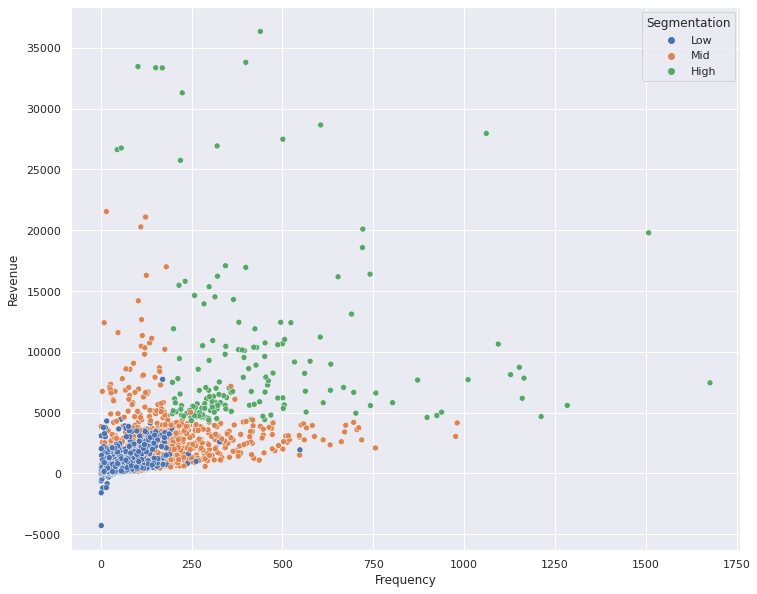

In [ ]:
# clustering on Frequency vs Revenue
plt.figure(figsize=(12,10))
sns.scatterplot(data=final_rfm.query("Revenue < 50000 and Frequency < 2000")
                               , x="Frequency", y="Revenue", hue="Segmentation");

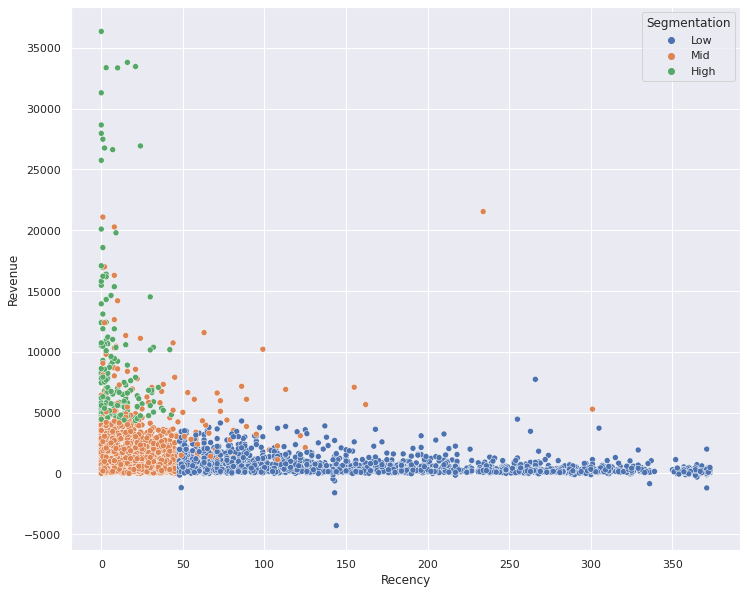

In [ ]:
# clustering on Recency vs Revenue
plt.figure(figsize=(12,10))
sns.scatterplot(data=final_rfm.query("Revenue < 50000 and Frequency < 2000")
                               , x="Recency", y="Revenue", hue="Segmentation");

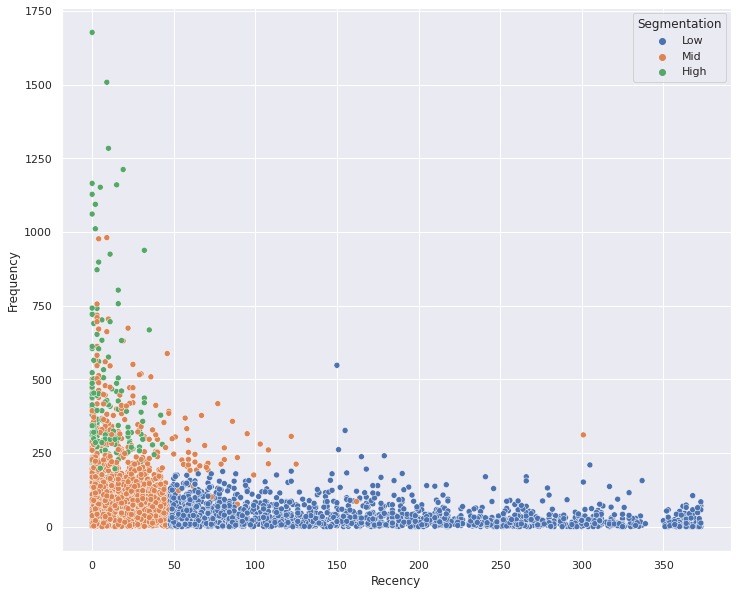

In [ ]:
# clustering on Revenue
plt.figure(figsize=(12,10))
sns.scatterplot(data=final_rfm.query("Revenue < 50000 and Frequency < 2000")
                               , x="Recency", y="Frequency", hue="Segmentation");

# 8 - Optional: Another way to cluster using Kmeans

Alternatively of calculating and picking RFM score, we can keep data intact and use K-Means on the hold data

In [ ]:
data_new =  final_rfm[['CustomerID','Recency','Frequency','Revenue']]
data_new = data_new.set_index('CustomerID')
data_new

,Recency,Frequency,Revenue
CustomerID,,,
12346.0,325,2,0.00
12829.0,321,12,253.05
12831.0,261,9,215.05
12834.0,282,18,312.38
12845.0,266,27,354.09
...,...,...,...
18252.0,50,98,526.67
18255.0,88,6,103.30
18265.0,71,46,801.51


In [ ]:
data_new.describe()

,Recency,Frequency,Revenue
count,3950.000000,3950.000000,3950.000000
mean,90.778481,91.614684,1713.385669
std,100.230349,220.557389,6548.608224
min,0.000000,1.000000,-4287.630000
25%,16.000000,17.000000,282.255000
50%,49.000000,41.000000,627.060000
75%,142.000000,101.000000,1521.782500
max,373.000000,7983.000000,256438.490000


After that we can use two kind of method to choose the best K for our cluster

## Elbow Method

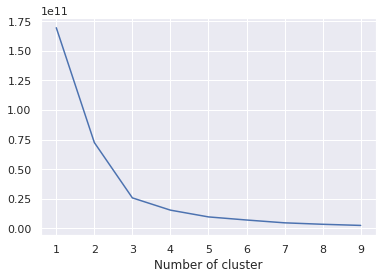

In [ ]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_new)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

## Silhouette score

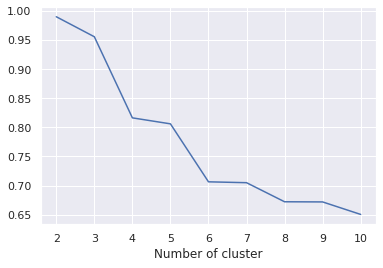

In [ ]:
from sklearn.metrics import silhouette_score

sil = {}
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be from 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data_new)
  labels = kmeans.labels_
  sil[k] = silhouette_score(data_new, labels, metric = 'euclidean')
  
plt.figure()
plt.plot(list(sil.keys()), list(sil.values()))
plt.xlabel("Number of cluster")
plt.show()

We can see that 2 and 3 seems to be a good cluster size

For keeping the diversity of clustering, we used K = 3

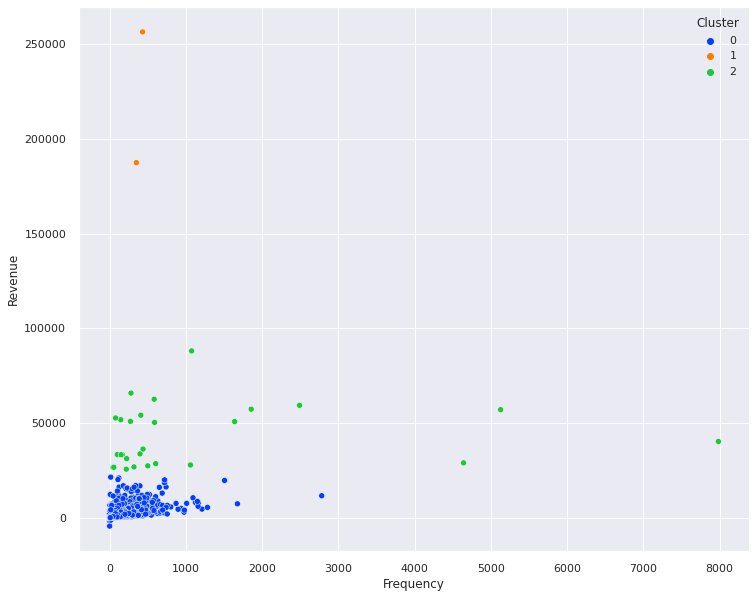

In [ ]:
plt.figure(figsize=(12,10))
sns.set_style("darkgrid")
sns.scatterplot(data=k_test
                               , x="Frequency", y="Revenue", hue="Cluster", palette="bright");

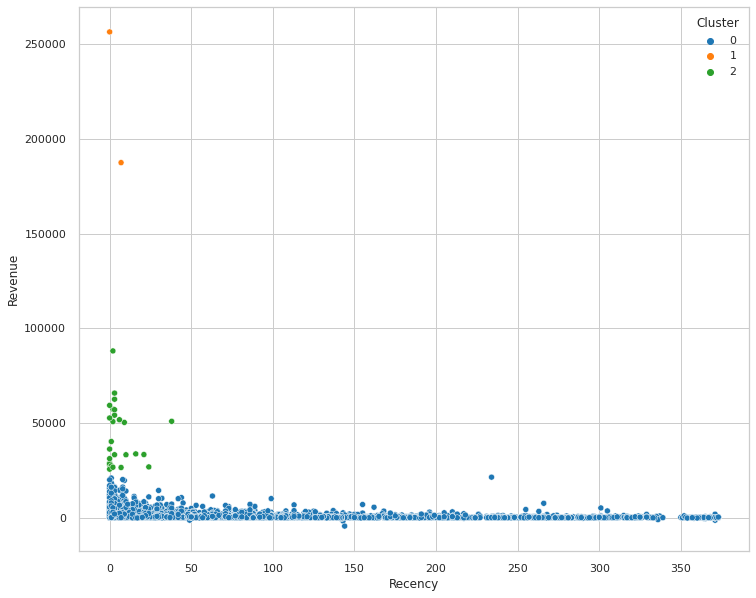

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=k_test
                               , x="Frequency", y="Revenue", hue="Cluster", palette="tab10");